In [15]:
%matplotlib inline

import pyarrow.parquet as pq
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from transformers import RobertaTokenizer, RobertaModel

In [16]:
df_orig = pq.read_table('PDFMalware2022.parquet').to_pandas()
df_orig.set_index('FileName', inplace=True)

In [17]:
df_orig.head()

,PdfSize,MetadataSize,Pages,XrefLength,TitleCharacters,isEncrypted,EmbeddedFiles,Images,Text,Header,...,AA,OpenAction,Acroform,JBIG2Decode,RichMedia,Launch,EmbeddedFile,XFA,Colors,Class
FileName,,,,,,,,,,,,,,,,,,,,,
aedaf3c5428a2e3ba600c44b96ad78dfdf8ed76e7df129bcd8174d83b77a9c33,8.0,180.0,1.0,11.0,0.0,0.0,0.0,0,No,\t%PDF-1.3,...,0,1,0,0,0,0,0,0,0.0,Malicious
fe767fb2584a10c010626263ea950643ac25f6ca24628f2c4879f0c2d11946aa,15.0,224.0,0.0,20.0,7.0,0.0,0.0,0,No,\t%PDF-1.6,...,0,0,1,0,0,0,8,1,0.0,Malicious
544c5223ee301affad514b6fa585b3191625aba0a7222b31747a96f050c7a76b,4.0,468.0,2.0,13.0,16.0,0.0,0.0,0,Yes,\t%PDF-1.3,...,0,1,0,0,0,0,0,0,0.0,Malicious
669772e626deccb9cfb7eb6a61e13d248d0ea08f1abe152e0e56629c27769d82,17.0,250.0,1.0,15.0,0.0,0.0,0.0,0,No,\t%PDF-1.3,...,0,1,1,0,0,0,0,0,0.0,Malicious
e434c884f45a691b0bf33d765f61794007eb0b8bb9f590bc055c88ea3c089859,7.0,252.0,3.0,16.0,45.0,0.0,0.0,0,Yes,\t%PDF-1.3,...,0,1,0,0,0,0,0,0,0.0,Malicious


In [18]:
df_orig['Class'].value_counts()

Class
Malicious    5555
Benign       4468
Name: count, dtype: int64

In [19]:
from pyreal.transformers import Transformer, OneHotEncoder, MultiTypeImputer, fit_transformers, run_transformers, BoolToIntCaster

# Manual transformations ----------------------------------------
cat_cols = ["Text", "Header", "Class"]
cols_to_fix = df_orig.select_dtypes(exclude='number').columns
cols_to_fix = [col for col in cols_to_fix if col not in cat_cols]

df = df_orig.copy()

for col in cols_to_fix:
    df[col] = pd.to_numeric(df_orig[col], errors='coerce')

df['Text'] = df_orig['Text'].apply(lambda x: 1 if x == 'Yes' else 0 if x == 'No' else None)

def features_from_header(header):
    error_strings = ["error", "errno", "exception", "fail", "invalid", "null", "problem", "warn", "warning", "not found"]
    error = any(err in header.lower() for err in error_strings)
    standard_headers = ["\t%PDF-1.3","\t%PDF-1.4","\t%PDF-1.7","\t%PDF-1.6","\t%PDF-1.2","\t%PDF-1.5","\t%PDF-1.0","\t%PDF-1.1"]
    standard = any(std in header for std in standard_headers)
    return error, standard

df[["header_error", "header_standard"]] = df_orig[["Header"]].apply(lambda row: features_from_header(row.squeeze()), axis='columns', result_type='expand')
df = df.drop(columns='Header')
df.head()
    
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Class'), df['Class'], test_size=0.2, random_state=42)

# Additional Pyreal transformations -------------------------------
imputer = MultiTypeImputer()
bool_to_int = BoolToIntCaster()
transformers = [imputer, bool_to_int]

X_train_trans = fit_transformers(transformers, X_train)
X_test_trans = run_transformers(transformers, X_test)

# convert t_test from ["Benign", "Malware"] to [0, 1]
y_train = y_train.apply(lambda x: 0 if x == "Benign" else 1)
y_test = y_test.apply(lambda x: 0 if x == "Benign" else 1)


In [20]:
import pycaret.classification as pc

df_train = X_train_trans.copy()
df_train['Class'] = y_train

exp = pc.ClassificationExperiment()

exp.setup(data=df_train, target='Class')
exp.models()
best = exp.compare_models(sort='AUC', include=["rf", "dt"])

,Description,Value
0,Session id,2788
1,Target,Class
2,Target type,Binary
3,Original data shape,"(8018, 33)"
4,Transformed data shape,"(8018, 33)"
5,Transformed train set shape,"(5612, 33)"
6,Transformed test set shape,"(2406, 33)"
7,Numeric features,32
8,Preprocess,True
9,Imputation type,simple


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:04:15
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9938,0.9995,0.9952,0.9936,0.9944,0.9874,0.9874,0.0430
dt,Decision Tree Classifier,0.9865,0.9863,0.9875,0.9882,0.9878,0.9726,0.9727,0.0090


In [21]:
best

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=2788, verbose=0,
                       warm_start=False)

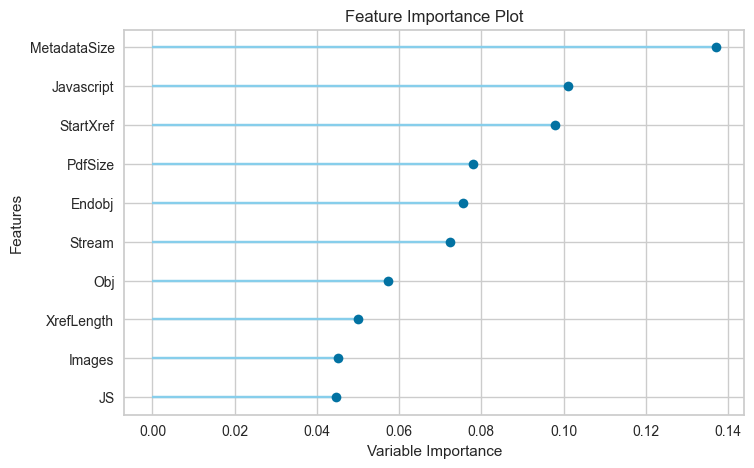

In [22]:
exp.plot_model(best, plot="feature")

In [23]:
exp.get_config('pipeline')

Pipeline(memory=FastMemory(location=C:\Users\Ola\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['PdfSize', 'MetadataSize', 'Pages',
                                             'XrefLength', 'TitleCharacters',
                                             'isEncrypted', 'EmbeddedFiles',
                                             'Images', 'Text', 'Obj', 'Endobj',
                                             'Stream', 'Endstream', 'Xref',
                                             'Trailer', 'StartXref', 'PageNo',
                                             'Encrypt', 'ObjStm', 'J...
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWrapper(exclude=None, include=[],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='most_frequent')))],
         verbose=False)

In [24]:
feature_descriptions = {
    "PdfSize": "Total size",
    "MetadataSize": "Size of metadata",
    "Pages": "Number of pages",
    "XrefLength": "Number of entries in Xref tables",
    "TitleCharacters": "Number of characters in the title",
    "isEncrypted": "Document encryption status",
    "EmbeddedFiles": "Number of embedded files",
    "Images": "Number of images",
    "Text": "Presence of text inside the PDF",
    "Header": "Presence of a valid PDF header",
    "Obj": "Number of total objects inside the PDF",
    "Endobj": "Number of endobj keywords",
    "Stream": "Number of streams in the PDF",
    "Endstream": "Number of endstreams keywords",
    "Xref": "Number of Xref tables",
    "Trailer": "Number of trailers inside the PDF",
    "StartXref": "Number of startxref keywords",
    "PageNo": "Number of pages",
    "Encrypt": "Document encryption status",
    "ObjStm": "Number of stream objects (ObjStm)",
    "JS": "Number of Javascript keywords",
    "Javascript": "Number of Javascript keywords",
    "AA": "Number of AA keywords",
    "OpenAction": "Number of OpenAction keywords",
    "Acroform": "Number of Acroform tags",
    "JBIG2Decode": "Presence of JBig2Decode filter",
    "RichMedia": "Number of RichMedia keywords",
    "Launch": "Number of Launch keywords",
    "EmbeddedFile": "Number of embedded files",
    "XFA": "Number of XFA tags",
    "Colors": "Number of unique colors used",
}

In [25]:
from pyreal import RealApp

app = RealApp(best, transformers=transformers, X_train_orig=X_train, y_train=y_train,
              id_column="FileName",
              feature_descriptions=feature_descriptions, pred_format_func=lambda x: "Benign" if x == 0 else "Malware")

#importances = app.produce_feature_importance()

<Axes: >

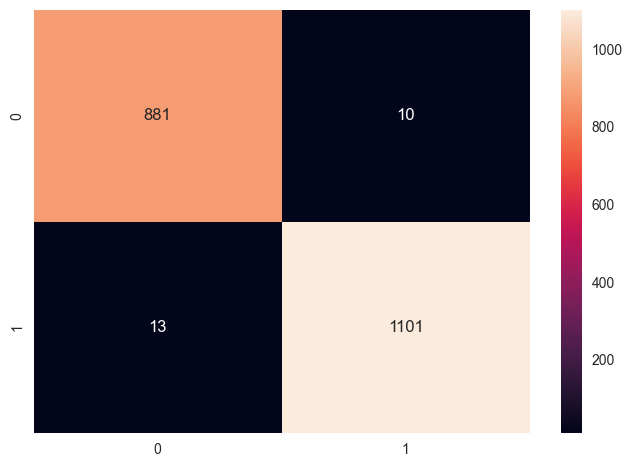

In [26]:
preds = app.predict(X_test, as_dict=False, format=False)

# plot a confusion matrix of preds vs y_test
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d')

In [27]:
from pyreal.visualize import feature_bar_plot

#feature_bar_plot(importances)

In [28]:
benign_examples = X_train[y_train == 0].sample(2, random_state=42)
malware_examples = X_train[y_train == 1].sample(2, random_state=42)

benign_contributions = app.produce_feature_contributions(benign_examples)
malware_contributions = app.produce_feature_contributions(malware_examples)

ValueError: All arrays must be of the same length